
# Section 5: Learning from only one sample: simple siamese neural networks
## Video 1: Discussion on methods with one sample (intro dataset)

Download the dataset here: https://github.com/brendenlake/omniglot

In [1]:
import sys
import numpy as np
from scipy.misc import imread
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Set logging dir for Tensorboard
logging_dir_n = 0

data_path = "datasets/omniglot/python/"
train_path = os.path.join(data_path,'images_background')
validation_path = os.path.join(data_path,'images_evaluation')

def load_images_from_directory(path,n=0):
    X=[]
    
    ## We load every alphabet seperately and append that to one tensor
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        alphabet_path = os.path.join(path,alphabet)
        
        ## Each character in alphabet is in a separate folder
        for letter in os.listdir(alphabet_path):
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
      
            if not os.path.isdir(letter_path):
                continue

            ## Read every image in this directory
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                image = image/255
                image = 1-image
                category_images.append(image)
            
            try:
                X.append(np.stack(category_images))
            #edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
    
    X = np.stack(X)
    return X

print("Loading training set")
Xtrain = load_images_from_directory(train_path)
print(Xtrain.shape)

print("Now loading evaluation set")
Xval = load_images_from_directory(validation_path)
print(Xval.shape)

Loading training set
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Japanese_(hiragana)
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Latin
loading alphabet: Greek
loading alphabet: Japanese_(katakana)
loading alphabet: Grantha
loading alphabet: N_Ko
loading alphabet: Balinese
loading alphabet: Tagalog
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Futurama
loading alphabet: Tifinagh
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Gujarati
loading alphabet: Early_Aramaic
loading alphabet: Hebrew
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Cyrillic
loading alphabet: Sanskrit
loading alphabet: 

In [2]:
import numpy.random as rng

def get_batch(data, batch_size):
    n_classes, n_examples, w, h = data.shape
    
    ## Initialise data we return in memory
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    ## Make a target vector with half same and half other categories
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    ## Pick the categories of characters we will return
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    for i in range(batch_size):
        category = categories[i]
        
        ## Choose two indixes from the amount of examples (20) we have
        idx_1 = rng.randint(0, n_examples)
        idx_2 = rng.randint(0, n_examples)
        
        #pick images of same class for 1st half, different for 2nd
#        if targets[i] == 1:
        if targets[i] == 0: ##### ROLAND NOTE: CHANGED TO DISTANCE FUNCTION
            category_2 = category # if target is set: pick from same category
        else:
            ## Pick new class by picking random number 
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[0][i,:,:,:] = data[category,idx_1].reshape(w,h,1)
        pairs[1][i,:,:,:] = data[category_2,idx_2].reshape(w,h,1)
  
    return pairs, targets


def make_oneshot_task(data, N):
    n_val, n_ex_val, w, h = data.shape

    categories = rng.choice(n_val,size=(N,),replace=False)
    true_category = categories[0]
    
    indices = rng.randint(0, n_ex_val,size=(N,))
    
    ex1, ex2 = rng.choice(n_ex_val,replace=False,size=(2,))
    
    ## Create a list with the same image N times as test image
    test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
    
    support_set = data[categories,indices,:,:]
    
    ## Create the targets and fill in true character
    targets = np.zeros((N,))    
    targets[0] = 1 # Set the first target to be the true character
    support_set[0,:,:] = data[true_category,ex2] # Fill in this caracter
    
    
    ## Reshape the data and return it
    support_set = support_set.reshape(N,w,h,1)
    pairs = [test_image,support_set]
    return pairs, targets

### Visualising the characters.

2


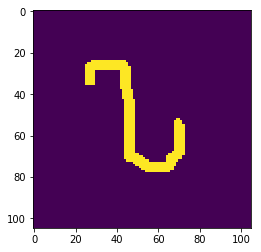

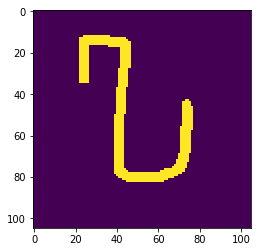

Distance: 0.0


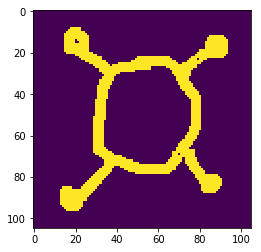

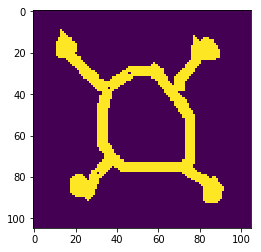

Distance: 0.0


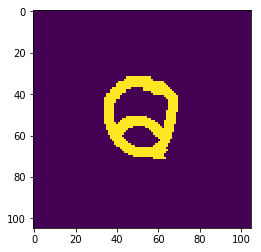

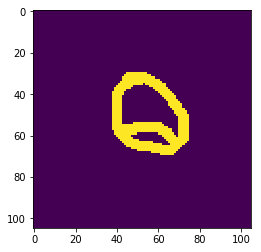

Distance: 0.0


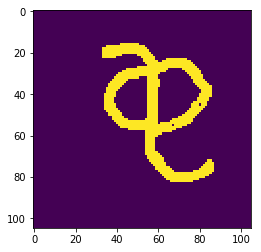

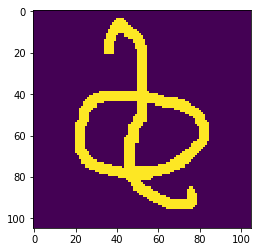

Distance: 0.0


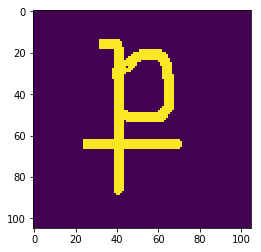

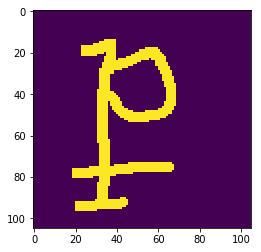

Distance: 0.0


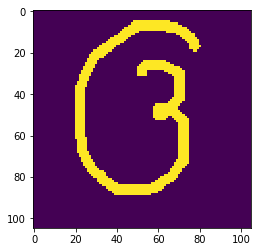

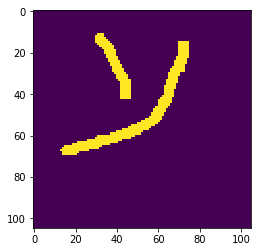

Distance: 1.0


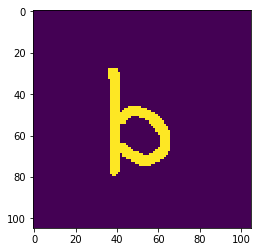

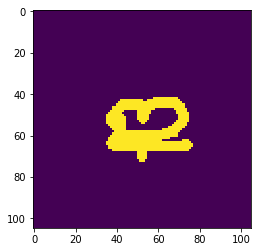

Distance: 1.0


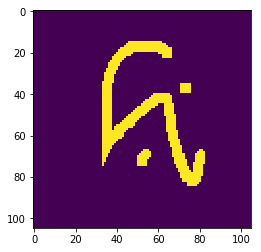

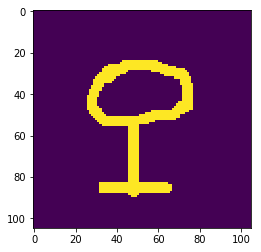

Distance: 1.0


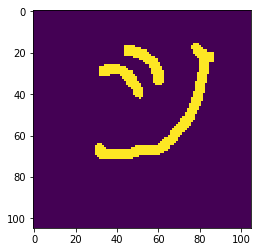

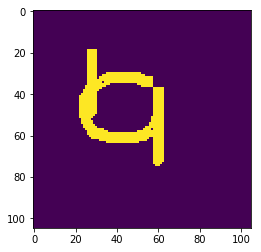

Distance: 1.0


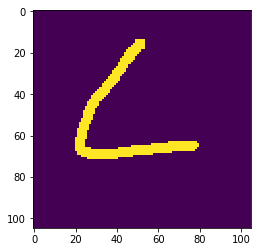

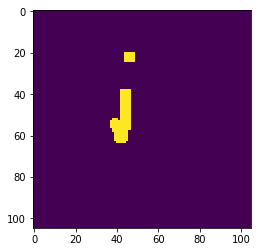

Distance: 1.0


In [3]:
pairs, targets = get_batch(Xtrain, 10)
print(len(pairs))
for i in range(len(pairs[0])):

    #print(pairs[0][i].shape)    
    image = np.reshape(pairs[0][i],(105,105))
    plt.imshow(image)
    plt.show()
    image = np.reshape(pairs[1][i],(105,105))
    plt.imshow(image)
    plt.show()
    print("Distance: " + str(targets[i]))


In [4]:
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(Xtrain)
# Xtrain = scaler.transform(Xtrain)
# Xtest = scaler.transform(Xtest)

## Video 2: What is a siamese neural network?
Now imagine what you would have to do to train a neural network to recognise these images. We could try to have 1623 output neurons of our network, and train it on the data that we have. Now we only have 20 characters as example per image (and less after we split train and test set), so it will be very difficult to train this. 

Instead we take a different approach: we ask our network: are these two images the same character? It's like asking a human: are these two the same person? 
![arnold1](https://upload.wikimedia.org/wikipedia/commons/d/d4/Arnold_Schwarzenegger_February_2015.jpg)
![arnold2](https://c1.staticflickr.com/1/450/19869372178_6bf3dc0a10_b.jpg)

Training a neural network to recognise every human being on the planet is downright impossible, but we could train it to indicate if two images are the same or not. 

In a siamese neural network we perform this task by making a neural network that maps input to an output vector. The idea is that this neural network maps the same charater to the same output vector every time. 

There are a lot of interesting things about this neural network: 
- The layers are shared during training
- You only need a dataset with characters either marked "the same" and "different"
- This neural network then works with similar data the network never saw before!

To actually build this neural network we are going to define a function that returns the layers of the input part of the network. Note that we use the variable scope to AND structure this nicely in Tensorboard, AND so we can reuse the layers we built earlier...

In [5]:

# , kernel_initializer=tf.random_normal_initializer(stddev=std_rn_conv)
def get_siamese_input_network(x_input, reuse):
    
    tf.summary.image('image_in'+str(reuse), x_input)
    
    with tf.variable_scope("first_part", reuse=reuse):
#         flattened = tf.contrib.layers.flatten(x_input)
#         dense0 = tf.layers.dense(flattened, 1024, activation=tf.nn.relu, name="dense01")
#         dense02 = tf.layers.dense(dense0, 512, activation=tf.nn.relu, name="dense02")
#         dense1 = tf.layers.dense(dense02, 128, activation=tf.nn.sigmoid, name="dense1")
#         conv1 = tf.layers.conv2d(x_input, 64, [10, 10], name='conv1', activation=tf.nn.relu)
#         maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
#         conv2 = tf.layers.conv2d(maxp1, 128, [7, 7], name='conv2', activation=tf.nn.relu)
#         maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
#         conv3 = tf.layers.conv2d(maxp2, 128, [4, 4], name='conv3', activation=tf.nn.relu)
#         maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')

        #conv4 = tf.layers.conv2d(maxp3, 256, [4, 4], name='conv4', activation=tf.nn.relu)
    
    
        conv1 = tf.layers.conv2d(x_input, 8, [10, 10], name='conv1', activation=tf.nn.relu)
        maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
        conv2 = tf.layers.conv2d(maxp1, 16, [7, 7], name='conv2', activation=tf.nn.relu)
        maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
        conv3 = tf.layers.conv2d(maxp2, 16, [4, 4], name='conv3', activation=tf.nn.relu)
        maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')

        conv4 = tf.layers.conv2d(maxp3, 32, [4, 4], name='conv4', activation=tf.nn.relu)
#         print(conv4)
        
#         #conv4 = tf.layers.conv2d(conv4, 32, [2,2], name="reduceconv", activation=tf.nn.relu)

        flattened = tf.contrib.layers.flatten(conv4)
#         print(flattened) # Print so we know if this is a reasonable size for this flattened layer
        
        dense1 = tf.layers.dense(flattened, 4096, activation=tf.nn.sigmoid, name="dense1")
        #dense1 = tf.layers.dense(flattened, 512, activation=tf.nn.sigmoid, name="dense1")
          
        
    
        
    return dense1


In [6]:
tf.reset_default_graph()

image1 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image1")
image2 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image2")
label_placeholder = tf.placeholder(dtype=tf.float32, shape=[None,1], name="labels")

## Get the outputs of the two images
out_1 = get_siamese_input_network(image1, None)
out_2 = get_siamese_input_network(image2, True)
print([x.name for x in tf.global_variables()])

writer = tf.summary.FileWriter(logdir='graphs/siamese_start', graph=tf.get_default_graph())


['first_part/conv1/kernel:0', 'first_part/conv1/bias:0', 'first_part/conv2/kernel:0', 'first_part/conv2/bias:0', 'first_part/conv3/kernel:0', 'first_part/conv3/bias:0', 'first_part/conv4/kernel:0', 'first_part/conv4/bias:0', 'first_part/dense1/kernel:0', 'first_part/dense1/bias:0']


### Combining outputs by this network, and determining the loss
After we determined the output of our shared network part we have to see how well they match. To do this we can take the so-called "L1-distance", which is simply the absolute of output 1 minus output 2. Of course not every difference we get here has the same importance when determining if two images are the same. This is why we add a last dense layer that will indicate if two vectors are equal or not...

In [7]:
l_one = tf.abs(tf.subtract(out_1,out_2))
prediction = tf.layers.dense(l_one, 1, activation=tf.nn.sigmoid, name="output")
mseloss = tf.losses.mean_squared_error(label_placeholder,prediction)

optimizer = tf.train.AdamOptimizer().minimize(mseloss)

training_summary = tf.summary.scalar('mseloss', mseloss)
merged = tf.summary.merge_all()

## Video 3: Training and testing a siamese neural network 

https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

https://sorenbouma.github.io/blog/oneshot/

In [8]:
writer = tf.summary.FileWriter(logdir='graphs/siam/'+str(logging_dir_n), graph=tf.get_default_graph())
logging_dir_n += 1
writer.flush()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
BATCH_SIZE = 64

for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    writer.add_summary(summary, iteration)

In [10]:

## Determine the accuracy 
CHOOSE_FROM_N = 5
TEST_COUNT = 300

correct_tested = 0

for _ in range(TEST_COUNT):
    inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
    pred = sess.run(prediction, feed_dict={image1: inputs[0], image2: inputs[1]})
#    pred = sess.run(distance, feed_dict={image1: inputs[0], image2: inputs[1]})
    
#     print(pred)
#     print(targets)
    maxindex = np.argmin(pred)

    if maxindex == 0:
        correct_tested += 1
print("Accuracy in best of " + str(CHOOSE_FROM_N))
print(correct_tested/TEST_COUNT)


Accuracy in best of 5
0.7666666666666667


## Video 4: alternative loss functions

### alternative loss function: log loss

log loss here

# Here is the log loss


In [11]:
epsilon = 0.00001
clipped_pred = tf.clip_by_value(prediction,epsilon,tf.subtract(1.0, epsilon),name="clippingtool")
log_true = tf.negative(tf.log(clipped_pred))
log_false = tf.negative(tf.log(tf.subtract(1.0,clipped_pred)))

true_part_of_loss = tf.multiply(label_placeholder,log_true)
false_part_of_loss = tf.multiply(tf.subtract(1.0,label_placeholder),log_false)

logloss_raw =  tf.add(true_part_of_loss,false_part_of_loss)
logloss = tf.reduce_mean(logloss_raw)



logloss_summary = tf.summary.scalar('logloss', logloss)
merged = tf.summary.merge_all()
optimizer = tf.train.AdamOptimizer().minimize(logloss)

In [12]:
writer = tf.summary.FileWriter(logdir='graphs/siam/'+str(logging_dir_n), graph=tf.get_default_graph())
logging_dir_n += 1
writer.flush()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
BATCH_SIZE = 64

for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    writer.add_summary(summary, iteration)

In [14]:
## Determine the accuracy 
CHOOSE_FROM_N = 5
TEST_COUNT = 300

correct_tested = 0

for _ in range(TEST_COUNT):
    inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
    pred = sess.run(prediction, feed_dict={image1: inputs[0], image2: inputs[1]})
    maxindex = np.argmin(pred)

    if maxindex == 0:
        correct_tested += 1
print("Accuracy in best of " + str(CHOOSE_FROM_N))
print(correct_tested/TEST_COUNT)

Accuracy in best of 5
0.6733333333333333



### alternative loss function: spring method with contrastive loss

spring method here

endan 

# Contrastive loss again


In [15]:
def contrastive_loss(model1, model2, labeltjes, margin):
    y = tf.reshape(labeltjes, [-1])
    with tf.name_scope("contrastive-loss"):
        l_two = tf.square(model1-model2)
        distance = tf.reduce_sum(l_two, axis=1)
        squared_distance = tf.sqrt(distance)
        negativepart = (1-y)*distance
        positivepart = y*tf.maximum(0.0,margin-distance)
        contrastiveloss = negativepart + positivepart
        contrastiveloss = tf.reduce_mean(contrastiveloss)
    return contrastiveloss, distance


margin=0.2
contrastiveloss, distance = contrastive_loss(out_1, out_2, label_placeholder, margin)
contr_loss_summary = tf.summary.scalar('contrastiveloss', contrastiveloss)
merged = tf.summary.merge_all()


optimizer = tf.train.AdamOptimizer().minimize(contrastiveloss)

In [16]:
writer = tf.summary.FileWriter(logdir='graphs/siam/'+str(logging_dir_n), graph=tf.get_default_graph())
logging_dir_n += 1
writer.flush()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
BATCH_SIZE = 64

for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    writer.add_summary(summary, iteration)

### Determining accuray

Now note that we can't use prediciton anymore, but instead have to look at the distance parameter

In [18]:
## Determine the accuracy 


CHOOSE_FROM_N = 5
TEST_COUNT = 300

correct_tested = 0

for _ in range(TEST_COUNT):
    inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
    dist = sess.run(distance, feed_dict={image1: inputs[0], image2: inputs[1]})
    maxindex = np.argmin(dist)

    if maxindex == 0:
        correct_tested += 1
print("Accuracy in best of " + str(CHOOSE_FROM_N))
print(correct_tested/TEST_COUNT)

Accuracy in best of 5
0.7866666666666666


## Video 5: speed of your network
By now we are building pretty large networks. What I want to do in this video is give you not only an intuition in what makes your network slow, but also give you the capability to calculate this yourself. 

### Batch sizes
One thing you can do to train "faster" is use a smaller batch size. The reason you take a batch of data is that it's often impossible to train on all your data at once (as both all data and all gradients don't fit into your computers memory). To get a "representation" of the data you randomly select samples, which you hope are a good distribution of your data. It's easy to get this distribution wrong if you have very sparse data. Let's say you are training on the MNIST data set. If you use a batch size of less than 10 you can't even have all digits in this single batch. You will then optimise your network parameters based on a very incomplete sample of your data. However, using a larger batch size of 1000 will require 100 times the amount of memory than your batch size of 10. 

There is no right or wrong batch size for any given problem. Depending on the time you have to train your algorithm, and the accuracy you expect, you can select a different batch size. 

In [ ]:
BATCH_SIZE = 16

### Example here of batch size
writer = tf.summary.FileWriter(logdir='graphs/siam/batchsize'+str(BATCH_SIZE), graph=tf.get_default_graph())
sess = tf.Session()
sess.run(tf.global_variables_initializer())



for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    writer.add_summary(summary, iteration)

In [ ]:
BATCH_SIZE = 128


writer = tf.summary.FileWriter(logdir='graphs/siam/batchsize'+str(BATCH_SIZE), graph=tf.get_default_graph())
sess = tf.Session()
sess.run(tf.global_variables_initializer())


for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    writer.add_summary(summary, iteration)


### Dense layers
A big factor in real-time training time can be the time your dense layers need to computer. In the case of our siamese neural network, there is a dense layer just before the networks join together, in the `get_siamese_input_network` function. Let's take a look at the last layer, and see what the effect of reshaping it has on the input of our dense layer. As we have several max pool layers before that layer, the width and height of the matrix are 6x6. 

| Last conv size:        | Reshaped size
| ------------- |:-------------:|
| 6x6x16      | 576 |
| 6x6x32      | 1152      |
| 6x6x128     | 4608      |

Now these sizes don't seem really scare as output of a convolutional layer, but they become scary once you start calculating the amount of weights you need between two dense layers:

| Dense in:        | Dense out: | Weights |
| ------------- |:-------------:|----|
| 576         | 576       | 331.776|
| 576         | 1152      | 663.552|
| 576         | 4608      | 2.654.208|
| 1152         | 576       | 663.552|
| 1152        | 1152      | 1.327.104|
| 1152        | 4608      | 5.308.416|
| 4608        | 576       | 2.654.208|
| 4608        | 1152      | 5.308.416|
| 4608         | 4608      | 21.233.664|


Now let's calculate how much memory we need to have to store these weights, assuming you use floating point numbers which take four bytes per weight: 


| Dense in:        | Dense out: | Weights | Memory: |
| ------------- |:-------------:|----|:-------:|
| 576         | 576       | 331.776 | 1.33 MB |
| 576         | 4608      | 2.654.208 | 10.62 MB |
| 1152         | 576       | 663.552 | 2.65 MB |
| 1152        | 4608      | 5.308.416 | 21.23 MB |
| 4608        | 576       | 2.654.208 | 10.62 MB |
| 4608         | 4608      | 21.233.664 | 84.93 MB |

Going from 576 to 4608 gives you only 8 times as many output neurons, but a 4608x4608 matrix takes 64 times the memory of a 576x576 matrix. 

From now on, think about how many input and output neurons you need, and while choosing your architecture try to keep your layers small. 

In [ ]:
def get_siamese_input_network_with_paramdict(x_input, reuse, parameter_dictionary):
    
    tf.summary.image('image_in'+str(reuse), x_input)
    
    with tf.variable_scope("first_part", reuse=reuse):
        conv1 = tf.layers.conv2d(x_input, parameter_dictionary["conv1"], [10, 10], name='conv1', activation=tf.nn.relu)
        maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
        conv2 = tf.layers.conv2d(maxp1, parameter_dictionary["conv2"], [7, 7], name='conv2', activation=tf.nn.relu)
        maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
        conv3 = tf.layers.conv2d(maxp2, parameter_dictionary["conv3"], [4, 4], name='conv3', activation=tf.nn.relu)
        maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')

        conv4 = tf.layers.conv2d(maxp3, parameter_dictionary["conv4"], [4, 4], name='conv4', activation=tf.nn.relu)

        flattened = tf.contrib.layers.flatten(conv4)

        dense1 = tf.layers.dense(flattened, parameter_dictionary["dense1"], activation=tf.nn.sigmoid, name="dense1")
    return dense1


In [ ]:
def test_hyperparameters(hyperdict, runname):
    tf.reset_default_graph()
    image1 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image1")
    image2 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image2")
    label_placeholder = tf.placeholder(dtype=tf.float32, shape=[None,1], name="labels")


    ## Get the outputs of the two images
    out_1 = get_siamese_input_network_with_paramdict(image1, None, hyperdict)
    out_2 = get_siamese_input_network_with_paramdict(image2, True, hyperdict)

    ## Determine loss and add it to summary
    contrastiveloss, distance = contrastive_loss(out_1, out_2, label_placeholder, margin)
    contr_loss_summary = tf.summary.scalar('contrastiveloss', contrastiveloss)
    merged = tf.summary.merge_all()

    ## The optimizer
    optimizer = tf.train.AdamOptimizer().minimize(contrastiveloss)
    
    ## New session and writer
    writer = tf.summary.FileWriter(logdir='graphs/'+runname, graph=tf.get_default_graph())
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    
    ## Train for 300 iterations
    BATCH_SIZE = 32
    for iteration in range(300):
        pairs, targets = get_batch(Xtrain, BATCH_SIZE)
        targets = [[t] for t in targets]

        _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
        writer.add_summary(summary, iteration)


def get_standard_dict():
    paramdict = dict()
    paramdict['conv1'] = 16
    paramdict['conv2'] = 32
    paramdict['conv3'] = 32
    paramdict['conv4'] = 32
    paramdict['dense1'] = 512
    return paramdict

In [ ]:

standarddict = get_standard_dict()
for dense_size in [8,32,128,512,2048,4096]:
    runname="densesize"+str(dense_size)
    standarddict['dense1'] = dense_size
    test_hyperparameters(standarddict, runname)    
   
    ## Determine the accuracy 
    CHOOSE_FROM_N = 5
    TEST_COUNT = 300

    correct_tested = 0

    for _ in range(TEST_COUNT):
        inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
        dist = sess.run(distance, feed_dict={image1: inputs[0], image2: inputs[1]})
        maxindex = np.argmin(dist)

        if maxindex == 0:
            correct_tested += 1
    print("Accuracy in best of " + str(CHOOSE_FROM_N))
    print(correct_tested/TEST_COUNT)


### Convolutional layers
Now let's look at our convolutional layers. 

Last thing of this video is a note that it's important to keep several tradeoffs in mind: 
- The larger your network, the more features it can learn... But the larger your network, the more prone it is to overfitting. 
- The larger your network, the more feature it can learn... But the larger your network, the longer it takes to train it, and the more data you need. 
- 

In [ ]:
paramdict = get_standard_dict()
for conv_size in [2,4,8,16,32,64]:
    runname="convsize"+str(conv_size)
    paramdict['conv1'] = conv_size
    paramdict['conv2'] = 2*conv_size
    paramdict['conv3'] = 2*conv_size
    paramdict['conv4'] = 4*conv_size
    
    test_hyperparameters(paramdict, runname)    
    ## Determine the accuracy 
    CHOOSE_FROM_N = 5
    TEST_COUNT = 300

    correct_tested = 0

    for _ in range(TEST_COUNT):
        inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
        dist = sess.run(distance, feed_dict={image1: inputs[0], image2: inputs[1]})
        maxindex = np.argmin(dist)

        if maxindex == 0:
            correct_tested += 1
    print("Accuracy in best of " + str(CHOOSE_FROM_N))
    print(correct_tested/TEST_COUNT)


### Evaluation and conclusion
One thing to keep in mind is that the distance metric is the amount of dimensions specified in the last layer. If you increase the size of this layer the distance will naturally grow a bit. 